<a href="https://colab.research.google.com/github/Nikita018/Image-Segmentation/blob/master/src/Mobilenet224_animal_dataset_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive
drive.mount('/content/gdrive',force_remount=True)

Mounted at /content/gdrive


In [0]:
# installing the examples from TF
pip install -q git+https://github.com/tensorflow/examples.git


In [0]:
pip install -q pyyaml h5py

In [0]:
# importing the libraries and packages
import tensorflow as tf
import numpy as np
import os
from tensorflow_examples.models.pix2pix import pix2pix
import tensorflow_datasets as tfds
tfds.disable_progress_bar()
from tensorflow import keras
from IPython.display import clear_output
import matplotlib.pyplot as plt
import cv2
from google.colab import files
from keras.preprocessing import image
import os.path
from os import path

In [0]:
builder = tfds.builder('oxford_iiit_pet:3.1.0')
info = builder.info
# by setting register_checksums as True to pass the check
config = tfds.download.DownloadConfig(register_checksums = True)
builder.download_and_prepare(download_config=config)
dataset = builder.as_dataset()

In [0]:
dim=224

In [0]:
# normalize function makes the image pixel intensities range between 0 and 1 
# makes the classes of mask range from 0 to n
def normalize(input_image, input_mask):
  input_image = tf.cast(input_image, tf.float32) / 255.0
  input_mask -= 1
  return input_image, input_mask

def plot (img):
  plt.imshow(img)
  plt.show()

def upload_predict(model):
  uploaded = files.upload()
  for fn in uploaded.keys():
    path = '/content/' + fn
    test_img=cv2.imread(path,1)
    test_img =cv2.cvtColor(test_img,cv2.COLOR_BGR2RGB)
    test_img =cv2.resize(test_img,(dim,dim))
    img=test_img
    test_img = tf.cast(test_img, tf.float32) / 255.0
    x = np.expand_dims(test_img, axis=0)
    pred=model.predict(x)
    pred_0=pred[0]
    pred_max=np.zeros((pred_0.shape[0],pred_0.shape[1]))
    for i in range(pred_0.shape[0]):
      for j in range(pred_0.shape[1]):
        if pred_0[i,j,0]>pred_0[i,j,1] and pred_0[i,j,0]>pred_0[i,j,2]:
          pred_max[i,j]=0
        elif pred_0[i,j,1]>pred_0[i,j,0] and pred_0[i,j,1]>pred_0[i,j,2]:
          pred_max[i,j]=1
        else:
          pred_max[i,j]=2
    # plot(pred_max)
    fig, axs = plt.subplots(2,2, figsize=(10,10))
    plt.subplot(1, 2, 1)
    plt.imshow(img)
    plt.subplot(1, 2, 2)
    plt.imshow(pred_max)
    plt.show()


def portrait(model):
  uploaded = files.upload()
  for fn in uploaded.keys():
    path = '/content/' + fn
    img=cv2.imread(path,1)
  # img=cv2.imread('dog6.jpg')
    img =cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    img =cv2.resize(img,(dim,dim))

    blur=np.array([[1,2,1],[2,4,2],[1,2,1]])/16
    kernel = np.ones((5,5),np.float32)/25
    blur_low = cv2.filter2D(img,-1,blur)
    blur_high= cv2.filter2D(img,-1,kernel)

    test_img = tf.cast(img, tf.float32) / 255.0
    x = np.expand_dims(test_img, axis=0)
    pred=model.predict(x)
    pred_0=pred[0]
    pred_max=np.zeros((pred_0.shape[0],pred_0.shape[1]))
    for i in range(pred_0.shape[0]):
      for j in range(pred_0.shape[1]):
        if pred_0[i,j,0]>pred_0[i,j,1] and pred_0[i,j,0]>pred_0[i,j,2]:
          pred_max[i,j]=0
        elif pred_0[i,j,1]>pred_0[i,j,0] and pred_0[i,j,1]>pred_0[i,j,2]:
          pred_max[i,j]=1
        else:
          pred_max[i,j]=2

    # 2 is boundary
    # 1 is background
    # 0 is body 

    l,b,c=img.shape
    for i in range(l):
      for j in range(b):
        if pred_max[i,j]==0:
          blur_high[i,j,]=img[i,j,]
        if pred_max[i,j]==2:
          blur_high[i,j]=blur_low[i,j,]

    fig, axs = plt.subplots(2,2, figsize=(10,10))
    plt.subplot(1, 2, 1)
    plt.imshow(img)
    plt.subplot(1, 2, 2)
    plt.imshow(blur_high)
    plt.show()


In [0]:
# this function resizes the images to 224 X 224 
# for 50% of the images it flips the images for better generalization of the model
# the input object datapoint is expected to have the image and segmentation_mask

@tf.function
def load_image_train(datapoint):
  input_image = tf.image.resize(datapoint['image'], (dim, dim))
  input_mask = tf.image.resize(datapoint['segmentation_mask'], (dim, dim))
  if tf.random.uniform(()) > 0.5:
    input_image = tf.image.flip_left_right(input_image)
    input_mask = tf.image.flip_left_right(input_mask)
  input_image, input_mask = normalize(input_image, input_mask)
  return input_image, input_mask

In [0]:
# loading the image for test dataset, which won't be part of the tf graph
# there is no flipping required for the test dataset, as we need to evaluate them as it is
def load_image_test(datapoint):
  input_image = tf.image.resize(datapoint['image'], (dim,dim))
  input_mask = tf.image.resize(datapoint['segmentation_mask'], (dim, dim))
  input_image, input_mask = normalize(input_image, input_mask)
  return input_image, input_mask

In [0]:
# some statistics about the dataset
TRAIN_LENGTH = info.splits['train'].num_examples
BATCH_SIZE = 64
BUFFER_SIZE = 1000
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE
print("Train length:", TRAIN_LENGTH)

Train length: 3680


In [0]:
# loading the dataset from the object
train = dataset['train'].map(load_image_train, num_parallel_calls=tf.data.experimental.AUTOTUNE)
test = dataset['test'].map(load_image_test)

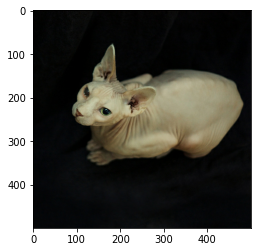

In [0]:
# exploring the elements contained in the dataset
for i in dataset['train'].take(1):
  # print(i.keys())
  filename=i['file_name']
  image=i['image']
  seg=i['segmentation_mask']
  img=image.numpy()
  plt.imshow(img)
  plt.show()
  seg=seg.numpy()
  # print(np.unique(seg))

In [0]:
# shuffling the training dataset randomly and prefetching the training dataset for faster train
train_dataset = train.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
test_dataset = test.batch(BATCH_SIZE)

In [0]:
# this function displays the images 
def display(display_list):
  plt.figure(figsize=(15, 15))
  title = ['Input Image', 'True Mask', 'Predicted Mask']
  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()

In [0]:
def unet_model(output_channels,down_stack,up_stack,dim):
  inputs = tf.keras.layers.Input(shape=[dim, dim, 3])
  x = inputs

  # Downsampling through the model
  skips = down_stack(x)
  x = skips[-1]
  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  
  for up, skip in zip(up_stack, skips):
    x = up(x)
    concat = tf.keras.layers.Concatenate()
    x = concat([x, skip])

  # This is the last layer of the model
  last = tf.keras.layers.Conv2DTranspose(
      output_channels, 3, strides=2,
      padding='same')  #64x64 -> 224x224

#       tf.keras.layers.Conv2DTranspose(
#     filters, kernel_size, strides=(1, 1), padding='valid', output_padding=None,
#     data_format=None, dilation_rate=(1, 1), activation=None, use_bias=True,
#     kernel_initializer='glorot_uniform', bias_initializer='zeros',
#     kernel_regularizer=None, bias_regularizer=None, activity_regularizer=None,
#     kernel_constraint=None, bias_constraint=None, **kwargs
# )

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

In [0]:
# Define the sequential model
def create_model(base_model,OUTPUT_CHANNELS,dim):
  # building these layers on top the pretrained model

  layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4
  ]
  layers = [base_model.get_layer(name).output for name in layer_names]
  down_stack = tf.keras.Model(inputs=base_model.input, outputs=layers)
  down_stack.trainable = False
  up_stack = [
    pix2pix.upsample(512, 3),  # 4x4 -> 8x8
    pix2pix.upsample(256, 3),  # 8x8 -> 16x16
    pix2pix.upsample(128, 3),  # 16x16 -> 32x32
    pix2pix.upsample(64, 3),   # 32x32 -> 64x64
  ]
  model = unet_model(OUTPUT_CHANNELS,down_stack,up_stack,dim)

  model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

  return model

In [0]:
# Model specific details

OUTPUT_CHANNELS = 3
# pretrained MobileNetV2 model from keras applications
base_model = tf.keras.applications.MobileNetV2(input_shape=[dim, dim, 3], include_top=False)
model = create_model(base_model,OUTPUT_CHANNELS,dim)
model.summary()

Model: "model_33"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_22 (InputLayer)           [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
model_32 (Model)                [(None, 112, 112, 96 1841984     input_22[0][0]                   
__________________________________________________________________________________________________
sequential_64 (Sequential)      (None, 14, 14, 512)  1476608     model_32[1][4]                   
__________________________________________________________________________________________________
concatenate_64 (Concatenate)    (None, 14, 14, 1088) 0           sequential_64[0][0]              
                                                                 model_32[1][3]            

In [0]:
def create_mask(pred_mask):
  pred_mask = tf.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0]

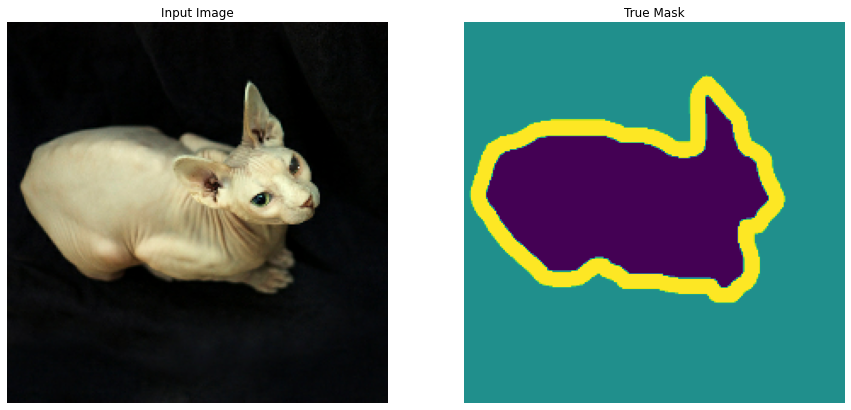

In [0]:
for image, mask in train.take(1):
  sample_image, sample_mask = image, mask
  display([sample_image, sample_mask])

In [0]:
def show_predictions(dataset=None, num=1,model_to_use=model):
  model=model_to_use
  if dataset:
    for image, mask in dataset.take(num):
      pred_mask = model.predict(image)
      display([image[0], mask[0], create_mask(pred_mask)])
  else:
    display([sample_image, sample_mask,
             create_mask(model.predict(sample_image[tf.newaxis, ...]))])

In [0]:
class DisplayCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    clear_output(wait=True)
    show_predictions()
    print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

In [0]:
checkpoint_path = "/content/gdrive/My Drive/Spring 2020/Machine Learning/Project/MobileNet_UNet/checkpoint/cp"+str(dim)+"/cp"+str(dim)+".ckpt"
print(checkpoint_path)
checkpoint_dir = os.path.dirname(checkpoint_path)

/content/gdrive/My Drive/Spring 2020/Machine Learning/Project/MobileNet_UNet/checkpoint/cp224/cp224.ckpt


/content/gdrive/My Drive/Spring 2020/Machine Learning/Project/MobileNet_UNet/checkpoint/cp224/cp224.ckpt


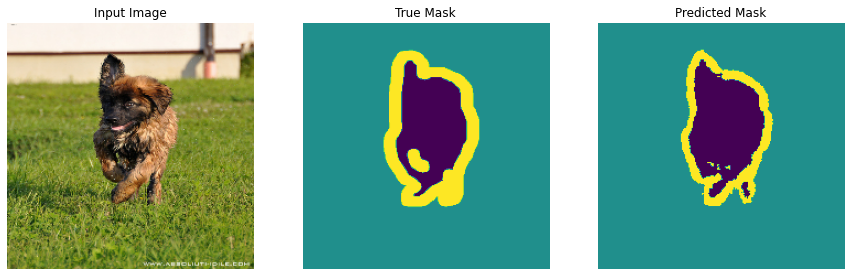

In [0]:
if path.exists(checkpoint_path+'.index'):
  model = create_model(base_model,OUTPUT_CHANNELS,dim)
  latest = tf.train.latest_checkpoint(checkpoint_dir)
  print(latest)
  model.load_weights(latest)
  show_predictions(test_dataset, 1,model)
else:

  cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                  save_weights_only=True,
                                                  verbose=1, frequency = 5)
  # Create a basic model instance
  model = create_model(base_model,OUTPUT_CHANNELS,dim)
  # Save the weights using the `checkpoint_path` format
  model.save_weights(checkpoint_path)

  EPOCHS = 20
  VAL_SUBSPLITS = 5
  VALIDATION_STEPS = info.splits['test'].num_examples//BATCH_SIZE//VAL_SUBSPLITS

  model_history = model.fit(train_dataset, epochs=EPOCHS,
                            steps_per_epoch=STEPS_PER_EPOCH,
                            validation_steps=VALIDATION_STEPS,
                            validation_data=test_dataset,
                            callbacks=[cp_callback])



In [0]:
# implementing portrait mode on the images based on semantic segmentation

Saving dog_haritha.jpg to dog_haritha.jpg


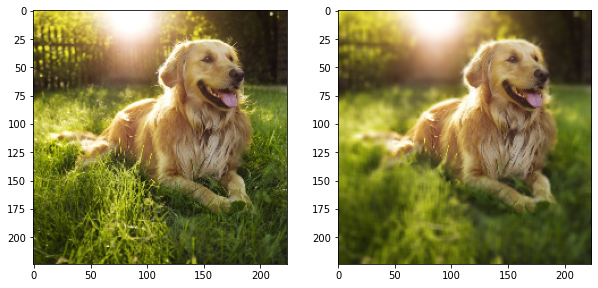

In [0]:
portrait(model)

Saving dog_haritha.jpg to dog_haritha (2).jpg


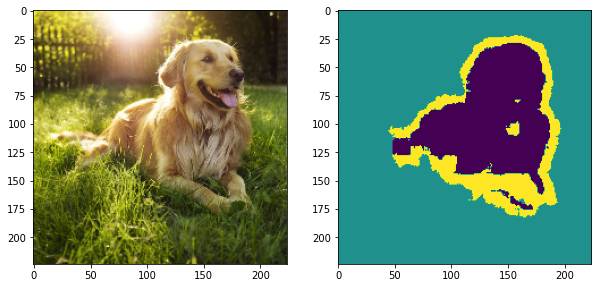

In [0]:
upload_predict(model)